In [1]:
# modules
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

# my score function
def myscore(y,yhat_prob,min_r=0.95,th_f=None):
    p,r,th = precision_recall_curve(y,yhat_prob[:,1])
    if th_f == None:
        th_f = np.concatenate(([0],th))[r>min_r].max()
    yhat = (yhat_prob[:,1]>th_f)+1-1
    ct = pd.crosstab(yhat,y).values
    if ct.shape[0] == 1:
        m = np.array([0,0,ct[0][0],ct[0][1]])
    else:
        m = ct.reshape((4,))
    acc = (m[0]+m[3])/m.sum()
    precision = m[3]/(m[2]+m[3])
    recall = m[3]/(m[1]+m[3])
    return acc, precision, recall, m[0], m[1], m[2], m[3], th_f

In [2]:
# read data
df = pd.read_csv('data_semi_train_clean.csv')
X = df.iloc[:,1:].values
Y = (df['Label']=='defect').values+1-1

In [3]:
X.shape

(11466, 303)

In [4]:
Y.shape

(11466,)

In [5]:
# normalization
from sklearn.preprocessing import StandardScaler
f = StandardScaler()
X = f.fit_transform(X)

In [6]:
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.2,random_state=0)

In [7]:
xtrain.shape

(9172, 303)

In [8]:
xval.shape

(2294, 303)

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
f = DecisionTreeClassifier()
f.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [11]:
yhat_prob = f.predict_proba(xtrain)
myscore(ytrain,yhat_prob,min_r=0.95)

(1.0, 1.0, 1.0, 8581, 0, 0, 591, 0.0)

In [12]:
yhat_prob = f.predict_proba(xval)
myscore(yval,yhat_prob,min_r=0.95)

(0.9402789886660854,
 0.5341614906832298,
 0.581081081081081,
 2071,
 62,
 75,
 86,
 0.0)

In [13]:
from sklearn.ensemble import RandomForestClassifier
f = RandomForestClassifier()
f.fit(xtrain,ytrain)

RandomForestClassifier()

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
f = GradientBoostingClassifier()
f.fit(xtrain,ytrain)

GradientBoostingClassifier()

In [15]:
from sklearn.svm import SVC
f = SVC(probability=True)
f.fit(xtrain,ytrain)

SVC(probability=True)

In [16]:
from sklearn.ensemble import RandomForestClassifier
f = RandomForestClassifier(n_estimators=200,min_samples_leaf=5,max_leaf_nodes=100)
f.fit(xtrain,ytrain)
yhat_prob = f.predict_proba(xval)
myscore(yval,yhat_prob,min_r=0.95)

(0.8635571054925893,
 0.31543624161073824,
 0.9527027027027027,
 1840,
 7,
 306,
 141,
 0.07281365520673126)

In [17]:
# parameter tuning
params = [10,20,50,100,200,500,1000]
res = np.zeros( (len(params),3) )
for i in range(len(params)):
    f = RandomForestClassifier(n_estimators=200,min_samples_leaf=5,max_leaf_nodes=params[i])
    f.fit(xtrain,ytrain)
    yhat_prob = f.predict_proba(xval)
    r = myscore(yval,yhat_prob)
    res[i,] = [i,params[i],r[1]]

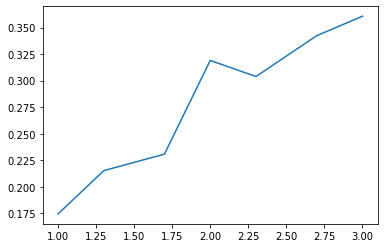

In [18]:
pd.DataFrame(res)
plt.plot(np.log10(res[:,1]),res[:,2])

In [19]:
from sklearn.svm import SVC
f = SVC(probability=True)
f.fit(xtrain,ytrain)
yhat_prob = f.predict_proba(xval)
myscore(yval,yhat_prob,min_r=0.95)

(0.9965126416739319,
 0.9929577464788732,
 0.9527027027027027,
 2145,
 7,
 1,
 141,
 0.6643787111773128)

In [20]:
myscore(yval,yhat_prob,min_r=0.99)

(0.9446381865736705,
 0.5384615384615384,
 0.9932432432432432,
 2020,
 1,
 126,
 147,
 0.00857288321372433)

In [21]:
# parameter tuning
C_list = 10**np.linspace(-5,5,num=6)
res = np.zeros( (len(C_list),3) )
for i in range(len(C_list)):
    f = SVC(C=C_list[i],probability=True)
    f.fit(xtrain,ytrain)
    yhat_prob = f.predict_proba(xval)
    r = myscore(yval,yhat_prob,min_r=0.99)
    res[i,] = [i,C_list[i],r[1]]

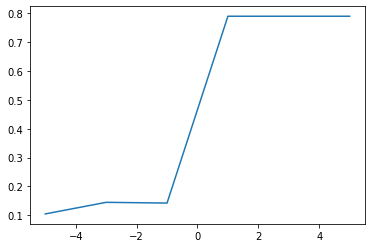

In [22]:
pd.DataFrame(res)
plt.plot(np.log10(res[:,1]),res[:,2])

In [23]:
pd.DataFrame(res)

,0,1,2
0,0.0,0.00001,0.104775
1,1.0,0.00100,0.144970
2,2.0,0.10000,0.142442
3,3.0,10.00000,0.790323
4,4.0,1000.00000,0.790323
5,5.0,100000.00000,0.790323


In [24]:
# final performance
f = SVC(C=10,probability=True)
f.fit(xtrain,ytrain)
yhat_prob = f.predict_proba(xval)

In [25]:
myscore(yval,yhat_prob,min_r=0.99)

(0.9825632083696599,
 0.7903225806451613,
 0.9932432432432432,
 2107,
 1,
 39,
 147,
 0.03155749258178255)

In [26]:
# neural network
from sklearn.neural_network import MLPClassifier
f = MLPClassifier(
        hidden_layer_sizes = (100,),
        activation = 'relu',
        alpha = 0.001,
        solver = 'adam',        
        batch_size = 'auto',
        learning_rate = 'constant',
        learning_rate_init = 0.01,
        random_state = 0,
        max_iter = 1000)
f.fit(xtrain,ytrain)

MLPClassifier(alpha=0.001, learning_rate_init=0.01, max_iter=1000,
              random_state=0)

In [27]:
yhat_prob = f.predict_proba(xval)
myscore(yval,yhat_prob,min_r=0.97)

(0.990409764603313,
 0.8888888888888888,
 0.972972972972973,
 2128,
 4,
 18,
 144,
 0.08965025362276142)

In [28]:
# neural network
from sklearn.neural_network import MLPClassifier
f = MLPClassifier(
        hidden_layer_sizes = (500,300,200),
        activation = 'logistic',
        alpha = 0.01,
        solver = 'adam',        
        batch_size = 'auto',
        learning_rate = 'constant',
        learning_rate_init = 0.01,
        random_state = 0,
        max_iter = 1000)
f.fit(xtrain,ytrain)

MLPClassifier(activation='logistic', alpha=0.01,
              hidden_layer_sizes=(500, 300, 200), learning_rate_init=0.01,
              max_iter=1000, random_state=0)

In [29]:
yhat_prob = f.predict_proba(xval)
myscore(yval,yhat_prob,min_r=0.95)

(0.990409764603313,
 0.9038461538461539,
 0.9527027027027027,
 2131,
 7,
 15,
 141,
 0.23778794943157436)

In [30]:
from sklearn.neighbors import KNeighborsClassifier
f = KNeighborsClassifier(n_neighbors=5)
f.fit(xtrain,ytrain)

KNeighborsClassifier()

In [31]:
yhat_prob = f.predict_proba(xtrain)
myscore(ytrain,yhat_prob,min_r=0.95)

(0.99792847797645,
 0.9948096885813149,
 0.9729272419627749,
 8578,
 16,
 3,
 575,
 0.4)

In [32]:
yhat_prob = f.predict_proba(xval)
myscore(yval,yhat_prob,min_r=0.95)

(0.9934612031386225,
 0.9290322580645162,
 0.972972972972973,
 2135,
 4,
 11,
 144,
 0.2)